## Necessary imports

In [1]:
from neuralyzer.datasets import FlatGrayPatchDataset
import torch

## Constants

In [2]:
n_concepts = 16
patch_size = 5
stride = 1
learning_rate = 0.05
batch_size = 16
init_low = 0
init_high = 1
n_iterations = 100000
image_file = "/Users/arnaudabreu/Downloads/lenna.png"

In [3]:
concepts = torch.nn.Linear(in_features=patch_size * patch_size, out_features=n_concepts, bias=False)
# initialize the weights of the concepts with random values between init_low and init_high (0 and 1 here to match input value range)
torch.nn.init.uniform_(concepts.weight, init_low, init_high)

Parameter containing:
tensor([[0.3277, 0.5264, 0.6994, 0.0180, 0.1733, 0.7107, 0.5256, 0.1595, 0.6221,
         0.7437, 0.1767, 0.3011, 0.3752, 0.0847, 0.9518, 0.2333, 0.7177, 0.3948,
         0.9044, 0.5395, 0.5121, 0.8185, 0.6542, 0.5253, 0.4142],
        [0.2912, 0.3387, 0.5260, 0.9781, 0.8449, 0.5419, 0.2164, 0.7449, 0.5670,
         0.1684, 0.9256, 0.4517, 0.8491, 0.9703, 0.7516, 0.1227, 0.0502, 0.8773,
         0.1394, 0.8694, 0.4599, 0.5506, 0.6368, 0.3209, 0.8758],
        [0.5969, 0.4926, 0.5387, 0.3322, 0.9971, 0.1146, 0.0499, 0.9972, 0.3089,
         0.4214, 0.6596, 0.0917, 0.7985, 0.3145, 0.6645, 0.9215, 0.0394, 0.1482,
         0.4692, 0.0715, 0.2882, 0.5973, 0.6956, 0.0330, 0.2837],
        [0.0276, 0.2491, 0.4000, 0.6974, 0.4254, 0.1961, 0.5822, 0.2312, 0.7071,
         0.9699, 0.5685, 0.1525, 0.4323, 0.2161, 0.4014, 0.5248, 0.5598, 0.5942,
         0.6213, 0.0992, 0.3094, 0.7384, 0.3473, 0.6882, 0.5839],
        [0.1993, 0.1505, 0.8202, 0.5546, 0.4771, 0.5830, 0.1632, 0

## Data Loader

In [4]:
dataset = FlatGrayPatchDataset(patch_size=patch_size, stride=stride, batch_size=batch_size)

## WTA implementation as temperature softmax

In [5]:
def temperature_softmax(
    logits: torch.Tensor,
    temperature: float = 1.0
):
    """
    Apply a softmax function to the logits with a temperature.
    
    Args:
        logits (torch.Tensor): the input logits
        temperature (float): the temperature to apply to the logits
        
    Returns:
        torch.Tensor: the output of the softmax function
    """
    return torch.nn.functional.softmax(logits/temperature, dim=1)

def winners_take_all(logits):
    """
    Apply the winners-take-all function to the logits.
    
    Args:
        logits (torch.Tensor): the input logits
        
    Returns:
        torch.Tensor: the output of the winners-take-all function (0 for all values except the maximum)
    """
    logit_max = logits.max(dim=1, keepdim=True).values
    wta = torch.where(logits < logit_max, torch.zeros_like(logits), logits)
    return wta

## Update rule

In [6]:
def oja_update_rule(
    weights: torch.Tensor,
    x: torch.Tensor,
    y: torch.Tensor,
    learning_rate: float
):
    """
    Compute new weights using the Oja update rule.
    
    Args:
        weights (torch.Tensor): The weights of the model with shape (out_features, in_features).
        x (torch.Tensor): The input data with shape (batch, in_features).
        y (torch.Tensor): The output data with shape (batch, out_features).
        learning_rate (float): The learning rate.
    """
    # add a feature dimension to x (to match the weights dimensions)
    inputs = x.unsqueeze(1) # (batch, 1, in_features)
    # add a feature dimension to y (to match the weights dimensions)
    outputs = y.unsqueeze(-1) # (batch, out_features, 1)
    # add a batch dimension to the weights (to match the inputs dimensions)
    synapses = weights.unsqueeze(0) # (1, out_features, in_features)
    # logits to probabilities
    z = temperature_softmax(y) # (batch, out_features)
    # set non-maximum values to zero in z (anti-Hebbian plasticity)
    winners = winners_take_all(z) # (batch, out_features)
    # add a feature dimension to z (to match the weights dimensions)
    winners = winners.unsqueeze(-1) # (batch, out_features, 1)
    # apply the Oja update rule
    # synaptic activity. Synapses will learn if the output is active
    synaptic_activity = synapses * outputs # (batch, out_features, in_features)
    # hebbian error. Active neurons will strengthen the affinity between the inputs and their synaptic weights
    error = inputs - synaptic_activity # (batch, out_features, in_features)
    delta = learning_rate * winners * error # (batch, out_features, in_features)
    updates = synapses + delta # (batch, out_features, in_features
    # average the updates over the batch
    updated_synapses = updates.mean(dim=0) # (out_features, in_features)
    return updated_synapses

## Training loop

In [7]:
loader = dataset.load(image_file)
for idx, batch in enumerate(loader):
    if idx > n_iterations:
        break
    x = batch["image"]
    y = concepts(x)
    if idx == 0:
        print(f"Shape of a batch of x: {x.shape}")
        print(f"Shape of a batch of y: {y.shape}")
        print(f"Batch number {idx}")
        print(f"First Input: {x[0]}")
        print(f"First Output: {y[0]}")
    # update the weights
    with torch.no_grad():
        w_updated = oja_update_rule(concepts.weight, x, y, learning_rate)
        concepts.weight.data = w_updated

Shape of a batch of x: torch.Size([16, 25])
Shape of a batch of y: torch.Size([16, 16])
Batch number 0
First Input: tensor([0.3976, 0.4303, 0.4185, 0.7029, 0.6599, 0.5046, 0.3753, 0.5442, 0.7967,
        0.6195, 0.4734, 0.3182, 0.6912, 0.8185, 0.4697, 0.3580, 0.3493, 0.7419,
        0.7473, 0.3268, 0.2946, 0.3925, 0.7391, 0.5965, 0.1990])
First Output: tensor([6.1615, 7.6476, 5.8927, 6.1312, 6.3732, 7.2433, 5.9374, 4.9398, 7.1851,
        7.7909, 6.9154, 5.1749, 7.7227, 6.3184, 6.9033, 5.7371],
       grad_fn=<SelectBackward0>)


In [8]:
# input tensor (x) shape: (batch, in_features)
# weight tensor (concepts.weight) shape: (out_features, in_features)
# output tensor shape: (batch, out_features)

# "repeat" way of doing things
# repeated_weights = einops.repeat(concepts.weight, 'o i -> b o i', b=32)
# test_repeated = repeated_weights * y.unsqueeze(-1)
# "unsqueeze" way of doing things
# test_unsqueezed = concepts.weight.unsqueeze(0) * y.unsqueeze(-1)

# check that the test_repeated and test_unsqueezed are the same
# print(torch.allclose(test_repeated, test_unsqueezed))
# display the shapes of the repeated weights
# print(repeated_weights.shape)


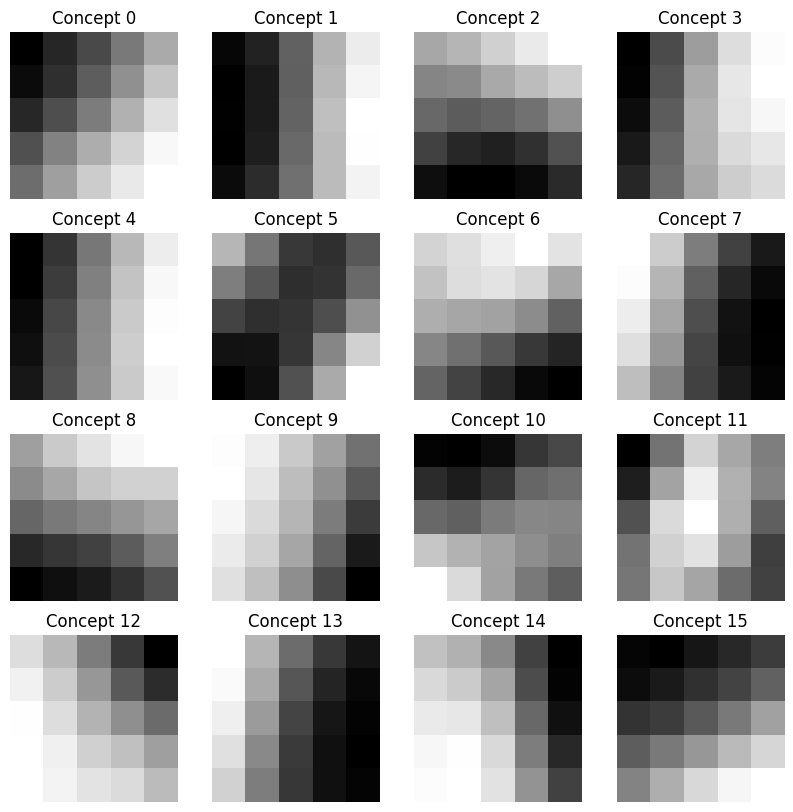

In [9]:
# plot concepts
import matplotlib.pyplot as plt
import numpy as np

n_size = int(np.sqrt(n_concepts))

fig, axs = plt.subplots(n_size, n_size, figsize=(10, 10))
for i in range(n_concepts):
    ax = axs[i//n_size, i%n_size]
    ax.imshow(concepts.weight[i].detach().numpy().reshape(patch_size, patch_size), cmap="gray")
    ax.axis("off")
    ax.set_title(f"Concept {i}")